---
## 一、数据分析


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',100)

In [60]:
sale = pd.read_csv('sales_train_validation.csv')

In [5]:
sale_data.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [82]:
sale_data.shape

(1716026, 31)

In [61]:
day_data = sale[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

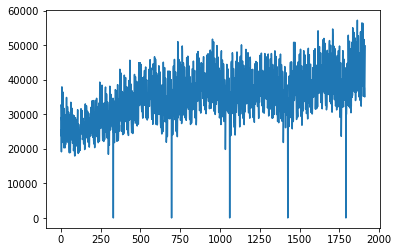

In [62]:
plt.plot(total_sum)

In [1]:
plt.hist(total_sum,bins= 100)

NameError: name 'plt' is not defined

---
## 二、特征工程

选定机器学习的建模方案，核心思想是对时间序列抽取窗口特征

抽取窗口特征：

- 前7天
- 前28天
- 前7天均值
- 前28天均值

关联其他维度信息

- 日期
- 价格

In [6]:
import sys
import lightgbm as lgb
from  datetime import datetime, timedelta

In [64]:
def create_train_data(train_start=750,test_start=1800,end=500,is_train=True,name=''):
    # 基本参数
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,end+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据
    price_data = pd.read_csv('sell_prices.csv',dtype=PRICE_DTYPES)
    price_data = price_data.loc[price_data.store_id == name,:]
    # 加载cal数据
    cal_data = pd.read_csv('calendar.csv',dtype=CAL_DTYPES)
    # 加载sale数据
    sale_data = pd.read_csv('sales_train_validation.csv',dtype=SALE_DTYPES,usecols=catcols+numcols)
    sale_data = sale_data.loc[sale_data.store_id == name,:]


    # 类别标签转换
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()


    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    # 注意提交格式里有一部分为空
    if not is_train:
        for day in range(end+1, end+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    return sale_data


def create_feature(sale_data, is_train=True, day=None):
    # 可以在这里加入更多的特征抽取方法
    # 获取7天前的数据，28天前的数据
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # 如果是测试集只需要计算一天的特征，减少计算量
    # 注意训练集和测试集特征生成要一致
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values  


    # 将获取7天前的数据，28天前的数据做移动平均
    wins = [7, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   

    # 处理时间特征
    # 有的时间特征没有，通过datetime的方法自动生成
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",
        }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")
    return sale_data

In [119]:
def predict_ensemble_NoWeight(train_cols,m_lgb,name):
    date = datetime(2016,4, 25)#训练集截至时间 1914  #datetime(2016,3, 28) # d_1886
    # alphas = [1.035, 1.03, 1.025, 1.02]
    # alphas = [1.028, 1.023, 1.018]
    #alphas = [1.035, 1.03, 1.025]
    #weights = [1/len(alphas)]*len(alphas)
    sub = 0.

    test_data = create_train_data(test_start=1800,end=1913,is_train=False,name=name)
    #print(test_data.columns)

    #for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    test_data_c = test_data.copy()
    cols = [f"F{i}" for i in range(1,29)]


    for i in range(0, 28):
        day = date + timedelta(days=i)
        #print(i, day)
        tst = test_data_c[(test_data_c.date >= day - timedelta(days=60)) & (test_data_c.date <= day)].copy()
        tst = create_feature(tst,is_train=False, day=day)
        tst = tst.loc[tst.date == day , train_cols]

        test_data_c.loc[test_data_c.date == day, "sales"] = m_lgb.predict(tst)

    # 改为提交数据的格式
    test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
    test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
    test_sub = test_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    test_sub.fillna(0., inplace = True)
    test_sub.sort_values("id", inplace = True)
    test_sub.reset_index(drop=True, inplace = True)
    test_sub.to_csv(f"{name}_sub_NoWeight.csv",index=False)
#     if icount == 0 :
#         sub = test_sub
#         sub[cols] *= weight
#     else:
#         sub[cols] += test_sub[cols]*weight
#     #print(icount, alpha, weight)
    
#     sub2 = sub.copy()
#     # 把大于28天后的validation替换成evaluation
#     sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
#     sub = pd.concat([sub, sub2], axis=0, sort=False)
#     sub.to_csv(f"{name}_sub.csv",index=False)

In [125]:
def train_model(train_data,valid_data):
    params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        "nthread": 8,
        "tweedie_variance_power":1.2,
    'verbosity': 1,
    'num_iterations' : 2200,
    'num_leaves': 128,
    "min_data_in_leaf": 104,
    }

    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=100)

    return m_lgb

In [126]:
store = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3']
starDay = [300]*10#[700,700,700,700,700,700,700,700,700,700]

In [127]:
future = ['event_name_2', 'event_type_2']

In [128]:
for name,day in zip(store,starDay):
    
    sale_data = create_train_data(train_start=day,end=1913,is_train=True,name=name)
    sale_data = create_feature(sale_data)

    # 清洗数据，选择需要训练的数据
    sale_data.dropna(inplace=True)
    
    cat_feats = ['item_id', 'dept_id', 'cat_id'] + ["event_name_1",'event_type_1'] + future
    useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday",'store_id','state_id']# + future
    train_cols = sale_data.columns[~sale_data.columns.isin(useless_cols)]
    X_train = sale_data[train_cols]
    y_train = sale_data["sales"]
    train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
    valid_inds = np.random.choice(len(X_train), 100000)
    valid_data = lgb.Dataset(X_train.iloc[valid_inds], label = y_train.iloc[valid_inds],categorical_feature=cat_feats, free_raw_data=False)
    print("{}开始啦---------------------------------------".format(name))
    m_lgb = train_model(train_data,valid_data)
    #m_lgb.save_model(f'{name}.txt')
    predict_ensemble_NoWeight(train_cols,m_lgb,name)


CA_1开始啦---------------------------------------


/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1382: UserWarning:

Using categorical_feature in Dataset.

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1117: UserWarning:

Overriding the parameters from Reference Dataset.

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:929: UserWarning:

categorical_column in param dict is overridden.



[100]	valid_0's rmse: 2.42853
[200]	valid_0's rmse: 2.30628
[300]	valid_0's rmse: 2.24488
[400]	valid_0's rmse: 2.20648
[500]	valid_0's rmse: 2.17267
[600]	valid_0's rmse: 2.14749
[700]	valid_0's rmse: 2.12589
[800]	valid_0's rmse: 2.10545
[900]	valid_0's rmse: 2.09338
[1000]	valid_0's rmse: 2.07863
[1100]	valid_0's rmse: 2.0631
[1200]	valid_0's rmse: 2.05085
[1300]	valid_0's rmse: 2.03821
[1400]	valid_0's rmse: 2.0251
[1500]	valid_0's rmse: 2.01164
[1600]	valid_0's rmse: 2.00329
[1700]	valid_0's rmse: 1.98683
[1800]	valid_0's rmse: 1.97816
[1900]	valid_0's rmse: 1.96698
[2000]	valid_0's rmse: 1.95626
[2100]	valid_0's rmse: 1.94556
[2200]	valid_0's rmse: 1.93638
CA_2开始啦---------------------------------------
[100]	valid_0's rmse: 1.89053
[200]	valid_0's rmse: 1.85522
[300]	valid_0's rmse: 1.82778
[400]	valid_0's rmse: 1.80421
[500]	valid_0's rmse: 1.78243
[600]	valid_0's rmse: 1.76608
[700]	valid_0's rmse: 1.75079
[800]	valid_0's rmse: 1.73832
[900]	valid_0's rmse: 1.72774
[1000]	valid

In [27]:
# 模型预测
train_colums = ['item_id', 'dept_id', 'cat_id', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'lag_7', 'lag_28', 'rmean_7_7', 'rmean_28_7',
       'rmean_7_28', 'rmean_28_28', 'week', 'quarter', 'mday']
for name in store:
    gbm = lgb.Booster(model_file=name+'.txt') #载入模型
    pd.DataFrame({
        'column': X_train.columns,
        'importance': m_lgb.feature_importance(),
    }).sort_values(by='importance')
    predict_ensemble(train_cols,gbm,name)#预测


In [99]:
#观察模型权重
im_fe = []
for name in store:
    gbm = lgb.Booster(model_file=name+'.txt') #载入模型
    im_fe.append(pd.DataFrame({
        'column': X_train.columns,
        'importance': gbm.feature_importance(),
    }).sort_values(by='importance'))

In [ ]:
pd.DataFrame({
        'column': X_train.columns,
        'importance': m_lgb.feature_importance(),
    }).sort_values(by='importance')

In [127]:
#调参
from hyperopt import fmin, tpe, hp, partial
# 自定义hyperopt的参数空间
space = {"max_depth": hp.randint("max_depth", 10),
         "num_trees": hp.randint("num_trees", 300),
         'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
         "bagging_fraction": hp.randint("bagging_fraction", 5),
         "num_leaves": hp.randint("num_leaves", 50),
         'sub_row': hp.uniform('sub_row',0, 1),
         'sub_feature': hp.uniform('sub_feature',0, 1),
         'lambda_l2': hp.uniform('lambda_l2',0, 1),
         'num_leaves': hp.randint('num_leaves', 120),
         'min_data_in_leaf': hp.randint('min_data_in_leaf', 100),
         'tweedie_variance_power': hp.uniform('tweedie_variance_power',0,1)
                 
         }

def argsDict_tranform(argsDict, isPrint=False):
    argsDict["max_depth"] = argsDict["max_depth"] + 5
    argsDict['num_trees'] = argsDict['num_trees'] + 100
    argsDict["learning_rate"] = argsDict["learning_rate"] * 0.02 + 0.05
    argsDict["bagging_fraction"] = argsDict["bagging_fraction"] * 0.1 + 0.5
    argsDict["num_leaves"] = argsDict["num_leaves"] * 3 + 10
    argsDict['tweedie_variance_power'] = argsDict['tweedie_variance_power'] + 1
    argsDict['min_data_in_leaf'] = argsDict['min_data_in_leaf'] + 50
    if isPrint:
        print(argsDict)
    else:
        pass

    return argsDict
from sklearn.metrics import mean_squared_error

def lightgbm_factory(argsDict):
    argsDict = argsDict_tranform(argsDict)

    params = {'nthread': -1,  # 进程数
              'max_depth': argsDict['max_depth'],  # 最大深度
              'num_trees': argsDict['num_trees'],  # 树的数量
              #'eta': argsDict['learning_rate'],  # 学习率
              'bagging_fraction': argsDict['bagging_fraction'],  # 采样数
              'num_leaves': argsDict['num_leaves'],  # 终点节点最小样本占比的和
              'objective': 'tweedie',
              #'feature_fraction': 0.7,  # 样本列采样
              #'lambda_l1': 0,  # L1 正则化
              'lambda_l2': argsDict['lambda_l2'] ,  # L2 正则化
              'bagging_seed': 100,  # 随机种子,light中默认为100
              'force_row_wise': True,
              'learning_rate': argsDict['learning_rate'],
              'sub_feature': argsDict['sub_feature'],
              'sub_row': argsDict['sub_row'],
              'tweedie_variance_power': argsDict['tweedie_variance_power'],
              'num_iterations': 1500,
              
              }
    params['metric'] = ['rmse']

    model_lgb = lgb.train(params, train_data, valid_sets=[valid_data],verbose_eval=100)

    return get_tranformer_score(model_lgb)

def get_tranformer_score(tranformer):

    model = tranformer
    prediction = model.predict(test_data, num_iteration=model.best_iteration)

    return np.sqrt(mean_squared_error(y_predict, prediction))




In [128]:
# 开始使用hyperopt进行自动调参
algo = partial(tpe.suggest, n_startup_jobs=1)
best = fmin(lightgbm_factory, space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1382: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



[100]	valid_0's rmse: 2.04736                         
[200]	valid_0's rmse: 2.02012                         
[100]	valid_0's rmse: 2.0365                                                    
[100]	valid_0's rmse: 2.28566                                                   
[200]	valid_0's rmse: 2.06662                                                   
[300]	valid_0's rmse: 2.03152                                                   
[100]	valid_0's rmse: 1.87176                                                   
[100]	valid_0's rmse: 1.8336                                                    
[100]	valid_0's rmse: 1.89371                                                   
[200]	valid_0's rmse: 1.84347                                                   
[100]	valid_0's rmse: 2.14041                                                   
[100]	valid_0's rmse: 2.04612                                                   
[200]	valid_0's rmse: 2.01594                                                   

In [129]:
RMSE = lightgbm_factory(best)
print('best :', best)
print('best param after transform :')
argsDict_tranform(best,isPrint=True)
print('rmse of the best lightgbm:', RMSE)

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1382: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	valid_0's rmse: 1.79091
[200]	valid_0's rmse: 1.72316
[300]	valid_0's rmse: 1.67536
best : {'bagging_fraction': 0.5, 'lambda_l2': 0.05011344402963704, 'learning_rate': 0.058374900891665485, 'max_depth': 12, 'min_data_in_leaf': 69, 'num_leaves': 295, 'num_trees': 388, 'sub_feature': 0.9989461548041529, 'sub_row': 0.06543578939994449, 'tweedie_variance_power': 1.1107920722132256}
best param after transform :
{'bagging_fraction': 0.55, 'lambda_l2': 0.05011344402963704, 'learning_rate': 0.05116749801783331, 'max_depth': 17, 'min_data_in_leaf': 119, 'num_leaves': 895, 'num_trees': 488, 'sub_feature': 0.9989461548041529, 'sub_row': 0.06543578939994449, 'tweedie_variance_power': 2.1107920722132256}
rmse of the best lightgbm: 1.5961147354660095


In [ ]:
m_lgb = train_model(train_data,valid_data) 

/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1382: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1117: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/xuelei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:929: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's rmse: 2.39327
[200]	valid_0's rmse: 2.27406
[300]	valid_0's rmse: 2.22258
[400]	valid_0's rmse: 2.18071
[500]	valid_0's rmse: 2.15637
[600]	valid_0's rmse: 2.13176
[700]	valid_0's rmse: 2.11441
[800]	valid_0's rmse: 2.09014
[900]	valid_0's rmse: 2.06851
[1000]	valid_0's rmse: 2.04812
[1100]	valid_0's rmse: 2.02672


In [56]:
y_true = sale.loc[:,'d_1886':'d_1913']
pre = pd.read_csv('submissionV3.csv').loc[:30489,'F1':]
print(wrmsse(pre,y_true,False,S,W,SW)[0])

2.7372964460575426


In [25]:
# # -*- coding: utf-8 -*-
# """
# Created on Wed Apr 29 13:29:28 2020

# @author: Lebesgue
# """
# 线下验证
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc
import os 
# #os.chdir('G:/kaggle/M5/juyterD')

# # 1914 1886 
# # 1913 1885

# # 转换数据类型，减少内存占用空间
# def reduce_mem_usage(df, verbose=True):
# # =============================================================================
# #     df = calendar
# # =============================================================================
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics: 
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df


# # 加载数据
# data_pass = './m5-forecasting-accuracy/'

# # sale数据
# sales = pd.read_csv('sales_train_validation.csv') 

# # 日期数据
# calendar = pd.read_csv('calendar.csv')
# calendar = reduce_mem_usage(calendar)

# # 价格数据
# sell_prices = pd.read_csv('sell_prices.csv')
# sell_prices = reduce_mem_usage(sell_prices)

# # 计算价格
# # 按照定义，只需要计算最近的 28 天售卖量（售卖数*价格），通过这个可以得到 weight
# # 可以不是 1886
# cols = ["d_{}".format(i) for i in range(1886-28, 1886)]
# data = sales[["id", 'store_id', 'item_id'] + cols]

# # 从横表改为纵表
# data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
#                  var_name="d", value_name="sale")

# # 和日期数据做关联
# data = pd.merge(data, calendar, how = 'left', 
#                 left_on = ['d'], right_on = ['d'])

# data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# # 和价格数据关联
# data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
# data.drop(columns = ['wm_yr_wk'], inplace=True)

# # 计算售卖量总价（售卖数量*商品单价）
# data['sale_usd'] = data['sale'] * data['sell_price']

# # 得到聚合矩阵
# # 30490 -> 42840
# # 需要聚合的维度明细计算出来 
# # 根据图片【聚合】对应下面就是
# # 2 3 4 5 6 7 8 9 10 11 12  
# dummies_list = [sales.state_id, sales.store_id, 
#                 sales.cat_id, sales.dept_id, 
#                 sales.state_id + sales.cat_id, sales.state_id + sales.dept_id,
#                 sales.store_id + sales.cat_id, sales.store_id + sales.dept_id, 
#                 sales.item_id, sales.state_id + sales.item_id, sales.id]

# # =============================================================================
# # dummies_list = [sales.state_id + sales.item_id]
# # =============================================================================


# # 全部聚合为一个， 最高 level 
# # 即 1 
# dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
#                                index=sales.index, columns=['all']).T]

# # 挨个计算其他 level 等级聚合
# for i, cats in enumerate(dummies_list):
#     #print(i)
#     dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# # 得到聚合矩阵
# roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
#                         names=['level','id'])#.astype(np.int8, copy=False)

# # =============================================================================
# #                                        0      1      2      ...  30487  30488  30489
# # level id                                                    ...                     
# # 0     all                                  1      1      1  ...      1      1      1
# # 1     CA                                   1      1      1  ...      0      0      0
# #       TX                                   0      0      0  ...      0      0      0
# #       WI                                   0      0      0  ...      1      1      1
# # 2     CA_1                                 1      1      1  ...      0      0      0
# #                                      ...    ...    ...  ...    ...    ...    ...
# # 11    HOUSEHOLD_2_516_TX_2_validation      0      0      0  ...      0      0      0
# #       HOUSEHOLD_2_516_TX_3_validation      0      0      0  ...      0      0      0
# #       HOUSEHOLD_2_516_WI_1_validation      0      0      0  ...      0      0      0
# #       HOUSEHOLD_2_516_WI_2_validation      0      0      0  ...      0      0      0
# #       HOUSEHOLD_2_516_WI_3_validation      0      0      0  ...      0      0      0
# # =============================================================================
      
# # 保存聚合矩阵 
# # 将矩阵的索引保存  
# roll_index = roll_mat_df.index 

# # =============================================================================
# # MultiIndex([( 0,                             'all'),
# #             ( 1,                              'CA'),
# #             ( 1,                              'TX'),
# #             ( 1,                              'WI'),
# #             ( 2,                            'CA_1'),
# #             ( 2,                            'CA_2'),
# #             ( 2,                            'CA_3'),
# #             ( 2,                            'CA_4'),
# #             ( 2,                            'TX_1'),
# #             ( 2,                            'TX_2'),
# #             ...
# #             (11, 'HOUSEHOLD_2_516_CA_1_validation'),
# #             (11, 'HOUSEHOLD_2_516_CA_2_validation'),
# #             (11, 'HOUSEHOLD_2_516_CA_3_validation'),
# #             (11, 'HOUSEHOLD_2_516_CA_4_validation'),
# #             (11, 'HOUSEHOLD_2_516_TX_1_validation'),
# #             (11, 'HOUSEHOLD_2_516_TX_2_validation'),
# #             (11, 'HOUSEHOLD_2_516_TX_3_validation'),
# #             (11, 'HOUSEHOLD_2_516_WI_1_validation'),
# #             (11, 'HOUSEHOLD_2_516_WI_2_validation'),
# #             (11, 'HOUSEHOLD_2_516_WI_3_validation')],
# #            names=['level', 'id'], length=42840)
# # =============================================================================

# # 将矩阵的值也保存 
# roll_mat_csr = csr_matrix(roll_mat_df.values)
# roll_mat_df.to_pickle('roll_mat_df.pkl')

# # 销毁对象 
# # 即销毁连接前的各个聚合组合的数列 与 连接后的矩阵 
# del dummies_df_list, roll_mat_df

# # 释放内存
# gc.collect()


# # 按照定义，计算每条时间序列 RMSSE 的权重:
# def get_s(drop_days=0):
    
#     """
#     drop_days: int, equals 0 by default, so S is calculated on all data.
#                If equals 28, last 28 days won't be used in calculating S.
#     """
    
#     # 要计算的时间序列长度 
#     # 如果drop_days为0 则有d_1 ~ d_1885 
#     d_name = ['d_' + str(i+1) for i in range(1885-drop_days)]
#     # 得到聚合结果 
#     # 矩阵乘法 (42840, 30490) * (30490, 1885) = (42840, 1885) 
#     # roll_mat_csr : 行为每个聚合层次 列为30490条销售索引 值代表取某列时属于某行的就标记1 否则为0 
#     # 列即为唯一商品id的索引 所以可以这么理解 如果aij=1 则意味着索引为j所对应的商品在i聚合层次里面有销售记录 
#     # sales[d_name] :  行为30489条销售索引 列为d_name那么多天的天字段 值为销售量 
#     # 结果即为每个聚合层次（行） d_name那么多天（行）的每天 的销售量 如果i为行 j为列 那么aij就是
#     # 第i个聚合层次下 j这天的销售量  
#     # 也可以这么写 roll_mat_csr @ sales[d_name].values
#     sales_train_val = roll_mat_csr * sales[d_name].values

#     # 按照定义，前面连续为 0 的不参与计算 
#     # 即找出每个聚类层次 前面连续取值为0（销售量为0的天）不参与计算 返回的是第一个不为0 的列索引j（第j-1天） 
#     start_no = np.argmax(sales_train_val>0, axis=1)
    
#     # 这些连续为 0 的设置为 nan 
#     # flag 的形状与 sales_train_val 的形状一致 
#     # np.diag(1/(start_no+1)) 对角矩阵 (42840, 42840) 加1的原因 一是为了分母非0 二是为了等下矩阵相乘 
#     # 能起到用是否小于1来判断该聚类层次的第几天开始是第一个非0的 
#     # 例如 第一行的聚类层次 在列索引j等于3的时候（即第4天）才开始不为0 则对角矩阵的第一个元素是 1/4 
#     # 乘过去后面一部分的第一行时 因其值为1 2 3 4 5...1885 那么除以4的话有 1/4 2/4 3/4 4/4 5/4 
#     # 可见只要判断是否小于1 就能把第一个非0值对应的天找出来 这里就是第4天了 因为4/4不小于1 
#     # 后面一部分的为 (42840, 1885) 生成的过程 里面是A:(1885, ) B:(42840, 1) A按照列方向复制了42840行 
# # =============================================================================
# #     flag = np.dot(np.diag(1/(start_no+1)), np.tile(np.arange(1,1886-drop_days),(roll_mat_csr.shape[0],1)))<1 
# # =============================================================================
#     # 上述对角阵内存开销较大 可以利用数组的广播功能 将其写成如下等价的式子 
# # =============================================================================
# #     flag = (1/(start_no+1)).reshape(len(start_no), -1) * np.tile(np.arange(1,1886-drop_days),(roll_mat_csr.shape[0],1)) < 1 
# # =============================================================================
#     # 事实上还可以把右边的部分同样利用数组的广播功能 免去tile 即等价于下面的式子 
#     flag = (1/(start_no+1)).reshape(len(start_no), -1) * np.arange(1,1886-drop_days) < 1
#     # 上式也可以写成规整一点的形式 
#     # (1/(start_no+1)).reshape(len(start_no), -1) * np.arange(1,1886-drop_days).reshape(-1, len(np.arange(1,1886-drop_days)))
#     # 返回的flag是如果上述矩阵乘积的值小于1（即连续为0的那些天） 则返回True 否则为False  
#     # np.where 作用是根据flag的布尔值 如果为True 则设置为nan 否则取sales_train_val原值 
#     sales_train_val = np.where(flag, np.nan, sales_train_val)

#     # 根据公式计算每条时间序列 rmsse的权重
#     # nansum忽略nan 对非nan进行相加 
#     # 就是公式分母那一部分 但不包含h 
#     weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1885-start_no-1)
    
#     return weight1

# # 每个聚合层次的权重 
# S = get_s(drop_days=0)

# # 根据定义计算 WRMSSE 的权重，这里指 w 
# def get_w(sale_usd):
# # =============================================================================
# #     sale_usd = data[['id','sale_usd']]
# # =============================================================================
#     """
#     """
#     # 得到最细维度的每条时间序列的权重 
#     # 30490个唯一商品id 形状为(30490,) 聚合求出对应的销售量 
#     total_sales_usd = sale_usd.groupby(
#         ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
#     # 通过聚合矩阵得到不同聚合下的权重
#     # (42840,) = (42840, 30490) * (30490,) 
#     weight2 = roll_mat_csr * total_sales_usd
#     # 因为聚合层次一共有12 所以需要乘以12  这里的分母np.sum(weight2)是进行了12次的加和,乘以12是为了变成一次的加和
#     return 12*(weight2/np.sum(weight2))


# W = get_w(data[['id','sale_usd']])

# SW = W/np.sqrt(S)

# sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
# sw_df.to_pickle('sw_df.pkl')


# 评分函数
# 得到聚合的结果
def rollup(v):
    '''
    '''
    return (v.T*roll_mat_csr.T).T


# 计算 WRMSSE 评估指标
def wrmsse(preds, y_true, score_only=False,s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw *(1/12))
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None]) / s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))*(1/12)
        return score, score_matrix


# 加载前面预先计算好的各个权重
file_pass = './'
sw_df = pd.read_pickle(file_pass+'sw_df.pkl')
S = sw_df.s.values
W = sw_df.w.values
SW = sw_df.sw.values

roll_mat_df = pd.read_pickle(file_pass+'roll_mat_df.pkl')
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)

# =============================================================================
# print(sw_df.loc[(11,slice(None))].sw)
# 
# print(1)
# =============================================================================


In [26]:
y_true = sale_data.loc[:,'d_1886':'d_1913']
pre = pd.read_csv('submissionV3.csv').loc[:30489,'F1':]
print(wrmsse(pre,y_true,False,S,W,SW)[0])

2.7239263233868902


In [69]:
store = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3']

In [108]:
CA1 = pd.read_csv('CA_1_sub.csv')
CA2 = pd.read_csv('CA_2_sub.csv')
CA3 = pd.read_csv('CA_3_sub.csv')
CA4 = pd.read_csv('CA_4_sub.csv')
TX1 = pd.read_csv('TX_1_sub.csv')
TX2 = pd.read_csv('TX_2_sub.csv')
TX3 = pd.read_csv('TX_3_sub.csv')
WI1 = pd.read_csv('WI_1_sub.csv')
WI2 = pd.read_csv('WI_2_sub.csv')
WI3 = pd.read_csv('WI_3_sub.csv')


In [109]:
fram = [CA1,CA2,CA3,CA4,TX1,TX2,TX3,WI1,WI2,WI3]

In [110]:
result = pd.concat(fram)

In [111]:
result.shape

(60980, 29)

In [112]:
result.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.750139,0.772505,0.771933,0.783363,0.942362,0.919770,1.248111,0.899572,0.786103,...,1.031215,1.129099,1.070506,0.760960,0.719134,0.720440,0.709261,0.935049,1.028566,1.007027
1,FOODS_1_002_CA_1_validation,0.479268,0.430599,0.407865,0.411677,0.419198,0.259251,0.384414,0.392110,0.494740,...,0.463434,0.627420,0.568591,0.489645,0.421386,0.495461,0.492164,0.506459,0.520890,0.535680
2,FOODS_1_003_CA_1_validation,0.781506,0.682876,0.638148,0.696206,0.810679,0.571588,0.627279,1.006633,0.964254,...,0.865541,0.872323,0.961457,0.779914,0.674325,0.691499,0.735979,0.871511,0.939229,0.894397
3,FOODS_1_004_CA_1_validation,0.073571,0.058494,0.061651,0.066924,0.082225,0.034896,0.019261,0.271307,0.245482,...,0.268973,0.394013,0.356173,0.308006,0.344749,0.347902,0.359056,0.399084,0.478224,0.457925
4,FOODS_1_005_CA_1_validation,1.316392,1.233851,1.427181,1.387651,1.530134,1.060117,1.149283,1.194807,1.025809,...,1.235766,1.412522,1.342656,1.062715,1.053345,0.997277,1.069564,1.312053,1.322963,1.397213


In [113]:
result.to_csv(f'result.csv',index=False)

In [68]:
from fbprophet import Prophet